<a href="https://colab.research.google.com/github/evelindna/sprint-analise-boaspraticas-pucrio/blob/main/MPV_MachineLearning_EvelinDallaNora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Machine Learning

**Nome:** Evelin Dalla Nora de Almeida

**Matrícula:** 4052025000854

**Dataset:** [Mall Customer Segmentation Data](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

# Definição do Problema  

Como cientista de dados de um shopping, recebi a tarefa de entender o comportamento dos clientes e identificar os clientes-alvo para uma campanha de marketing. Com o Dataset de Segmentação de Clientes de um Shopping possuo os dados necessários para resolver esse problema. O objetivo principal é colocar em prática o aprendizado da sprint de Machine Learning, como preparação dos dados, modelagem e treinamento e avaliação dos resultados, os dados presentes no dataset são fictícios e provenientes da internet.

## Hipóteses do Problema

Tracei as seguintes hipóteses:


*   É possível identificar clientes mais fiéis ao shopping?
* Quais insights valiosos é possível entregar ao time de Marketing?



## Tipo de tarefa & Área de aplicação

A condição é que o dataset fosse possível ser aplicado um algoritmo de machine learning (supervisionado ou não supervisionado) em um dos tipos de problema: classificação, regressão, clusterização ou previsão de séries temporais (forecasting).
Sendo o tipo da tarefa em questão, um problema de **clusterização** e área de aplicação é uma área de **dados tabulares**.

## Valor para o negócio

Agrupando os clientes será possível direcionar campanhas de marketing mais assertivas, que é o objetivo principal do projeto.

## Atributos do Dataset

| Nome da Coluna | Descrição | Valores de Exemplo |
|-------------|-------------|-------------|
| CustomerID| ID único do cliente | 1 |
| Gender | Gênero do cliente | Female |
| Age | Idade do cliente | 23 |
| Annual Income (k$) | Renda anual do cliente | 18 |
| Spending Score | A pontuação atribuída pelo shopping com base no comportamento do cliente e na natureza dos gastos | 40 |



# Biliotecas & Funções

In [1]:
import warnings
warnings.filterwarnings("ignore")

# === Setup básico e reprodutibilidade ===
import itertools
import os, random, time, sys, math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             silhouette_score)

from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


In [2]:
url = "https://raw.githubusercontent.com/evelindna/sprint-analise-boaspraticas-pucrio/refs/heads/main/mall_customers.csv"

df_original = pd.read_csv(url)
df = df_original.copy()

# Entendimento e Qualidade dos Dados

Primeiramente irei checar a consistência do dataset, quantas intâncias e atributos possui, os formatos das colunas e se há nulos que necessita tratamento.

In [3]:
print(f"O dataset possui {len(df)} instâncias e {len(df.columns)} atributos")
print("---------------------------------")
print(f"Os atributos são: ")
for x in df.columns: print(x)
print("---------------------------------")
print("Os tipos de coluna são: ")
df.dtypes

O dataset possui 200 instâncias e 5 atributos
---------------------------------
Os atributos são: 
CustomerID
Gender
Age
Annual Income (k$)
Spending Score (1-100)
---------------------------------
Os tipos de coluna são: 


,0
CustomerID,int64
Gender,object
Age,int64
Annual Income (k$),int64
Spending Score (1-100),int64


In [4]:
print(f"O dataset possui {df.duplicated().sum()} linhas duplicadas")

O dataset possui 0 linhas duplicadas


In [5]:
for x in df.columns:
  print(f"Quantidade de nulos na coluna {x}: {sum(df[x].isna())}")

Quantidade de nulos na coluna CustomerID: 0
Quantidade de nulos na coluna Gender: 0
Quantidade de nulos na coluna Age: 0
Quantidade de nulos na coluna Annual Income (k$): 0
Quantidade de nulos na coluna Spending Score (1-100): 0


In [6]:
df = df.rename(columns={'CustomerID': 'customer_id', 'Age': 'age', 'Annual Income (k$)': 'annual_income', 'Spending Score (1-100)': 'spending_score', 'Gender': 'gender'})

Não necessitando tratamentos proveniente do conhecimento adquirido da sprint de análise de dados, posso seguir com o trabalho. Abaixo faço uma análise exploratória

# Análise Exploratória

In [7]:
df.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


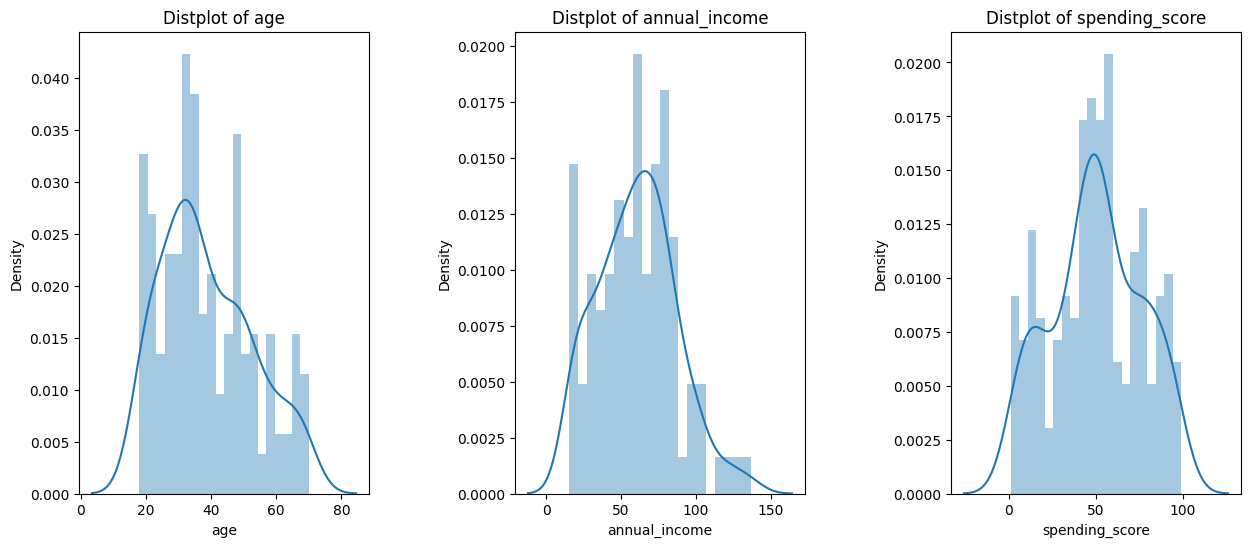

In [8]:
plt.figure(1 , figsize = (15 , 6))
n = 0
for x in ['age' , 'annual_income' , 'spending_score']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

No plot acima podemos ver a distribuição da idade, receita anual e score de gasto. A idade tem uma densidade maior em pessoas mais jovens, a receita anual é levemente semelhante a uma curva bimodal, querendo começar a formar um pico menor inicialmente. Já o score de gasto tem uma densidade maior mais no centro e uma leve distribuicao aos lados.

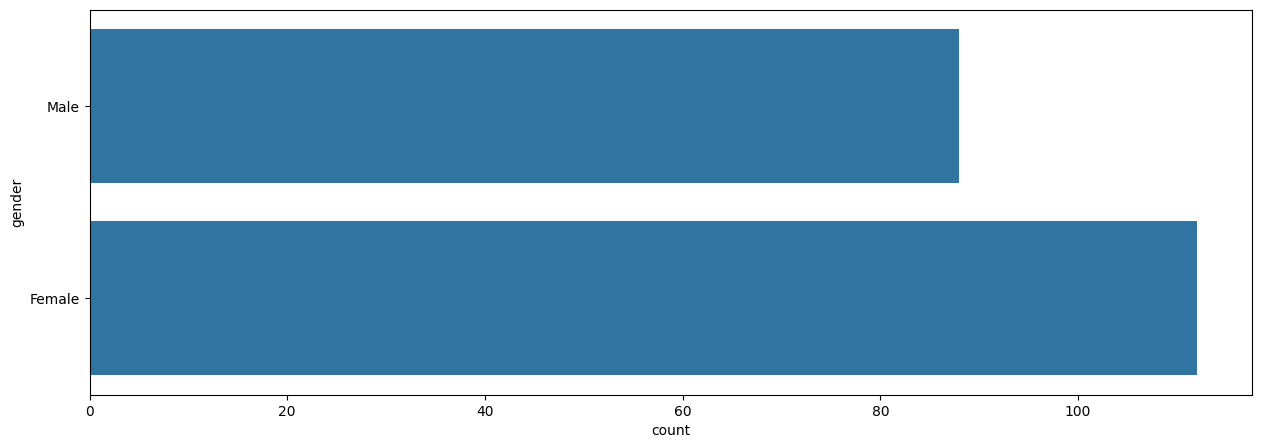

In [9]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'gender' , data = df)
plt.show()

Podemos evidenciar uma contagem maior de mulheres como cliente desse shopping

In [10]:
print(f"A porcentagem de clientes do genero feminino no shopping é: {(len(df[df['gender'] == 'Female']) * 100) / len(df)}%")

A porcentagem de clientes do genero feminino no shopping é: 56.0%


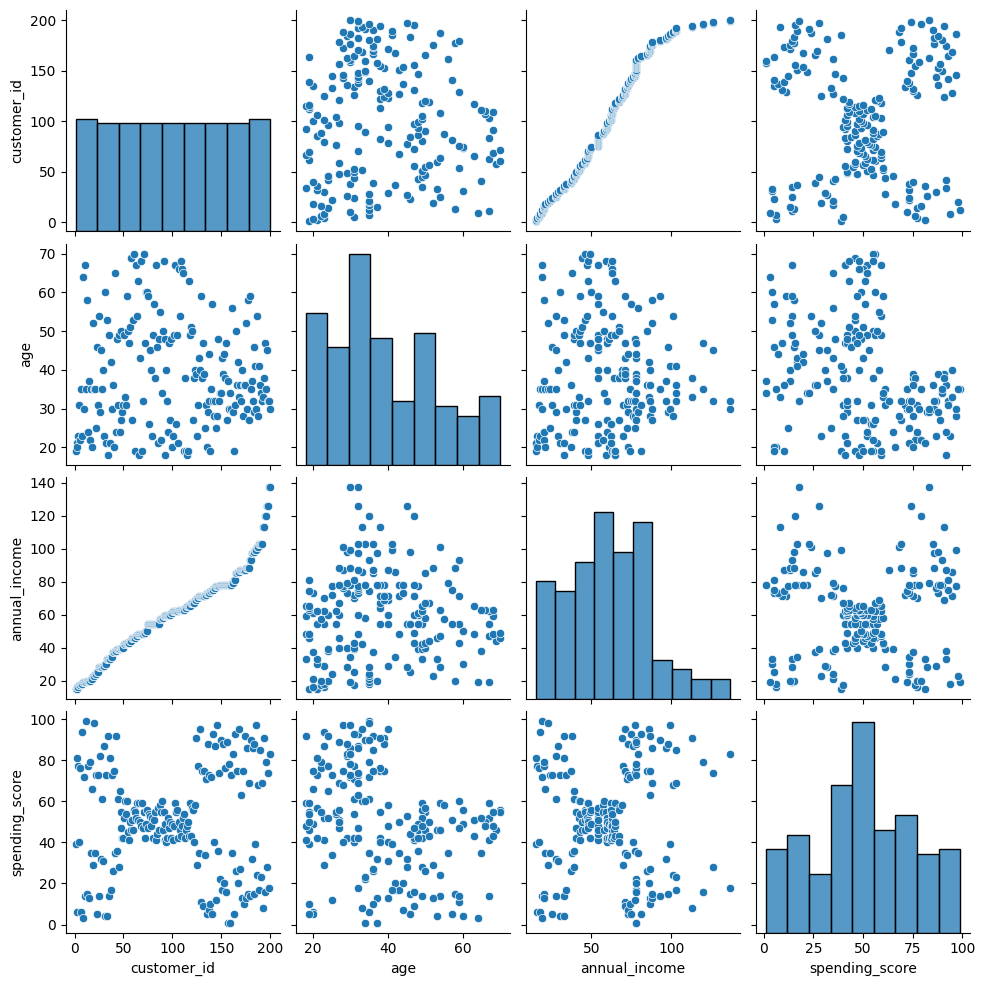

In [11]:
sns.pairplot(df)

Neste pairplot é possível evidenciar alguns clusters surgindo naturalmente ao plotar a dispersão dos dados. É possível ver que customer_id vs spending_score e spending_score vs annual_income possuem uma clusterização.

# Definição dos melhores parâmetros

Nesta sessão será realizado testes para determinar o melhor conjunto de features para realizar a clusterização bem como o melhor n_clusters usando como base o Silhouette Score.  

Escolhi o algoritmo KMeans pois é simples, possui uma boa velocidade de processamento e possui também referência do seu uso em diversos frameworks de marketing. Visto como o problema do projeto é um problema da área de marketing, reforçou a escolha do modelo.

Os dados não foram normalizados nem padronizados pois como evidenciado acima no pairplot, são distribuídos da mesma forma.

In [12]:
# Criação da feature booleana para o genero para ser possível aplicar na clusterização
df['gender_bool']  = df["gender"].map({"Male": 1, "Female": 0})

In [13]:
df_melhores_parametros = df[['annual_income', 'spending_score']]

In [14]:
columns_l = df_melhores_parametros.columns.tolist()

In [15]:
melhor_resultado = {"score": -1}

# Testar todas as combinações de colunas (de 2 até todas)
for r in range(2, len(columns_l)+1):
    for comb in itertools.combinations(columns_l, r):
        X = df_melhores_parametros[list(comb)]

        # Testar diferentes valores de n_clusters
        for k in range(2, 10):  # de 2 a 9 clusters
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(X)

            score = silhouette_score(X, labels)

            if score > melhor_resultado["score"]:
                melhor_resultado = {
                    "colunas": comb,
                    "n_clusters": k,
                    "score": score
                }

print("Melhor combinação encontrada:")
print(f"Colunas: {melhor_resultado['colunas']}")
print(f"n_clusters: {melhor_resultado['n_clusters']}")
print(f"Silhouette Score: {melhor_resultado['score']:.4f}")

Melhor combinação encontrada:
Colunas: ('annual_income', 'spending_score')
n_clusters: 5
Silhouette Score: 0.5539


Decidi afunilar as colunas para apenas duas pois a partir da análise exploratória já foi possível observar um agrupamento natural ao plotar as features selecionadas.

# Aplicação dos parâmetros e visualizações

In [16]:
# Criando a variável de entrada do modelo para realizar a clusterização
X = df.loc[:, melhor_resultado['colunas']]

In [17]:
# Aplicando o modelo com os parametros selecionados anteriormente
kmeans_final = KMeans(n_clusters=melhor_resultado["n_clusters"], random_state=42)

# Salvando os resultados do agrupamento numa nova coluna do df
df["cluster"] = kmeans_final.fit_predict(X)

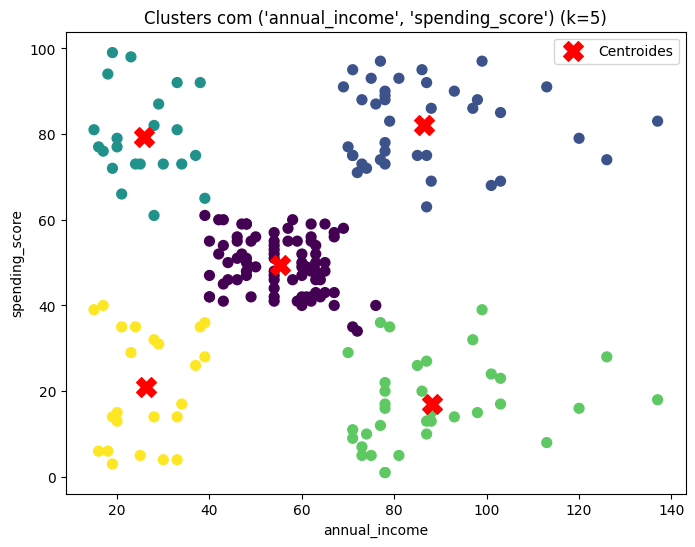

In [18]:
if len(melhor_resultado["colunas"]) == 2:
    plt.figure(figsize=(8,6))
    plt.scatter(
        df[melhor_resultado["colunas"][0]],
        df[melhor_resultado["colunas"][1]],
        c=df["cluster"], cmap="viridis", s=50
    )
    plt.scatter(
        kmeans_final.cluster_centers_[:,0],
        kmeans_final.cluster_centers_[:,1],
        c="red", marker="X", s=200, label="Centroides"
    )
    plt.xlabel(melhor_resultado["colunas"][0])
    plt.ylabel(melhor_resultado["colunas"][1])
    plt.title(f"Clusters com {melhor_resultado['colunas']} (k={melhor_resultado['n_clusters']})")
    plt.legend()
    plt.show()

# Conclusões

In [19]:
print("A quantidade de clientes em cada grupo é:")
df.groupby('cluster').size()

A quantidade de clientes em cada grupo é:


,0
cluster,
0,81
1,39
2,22
3,35
4,23


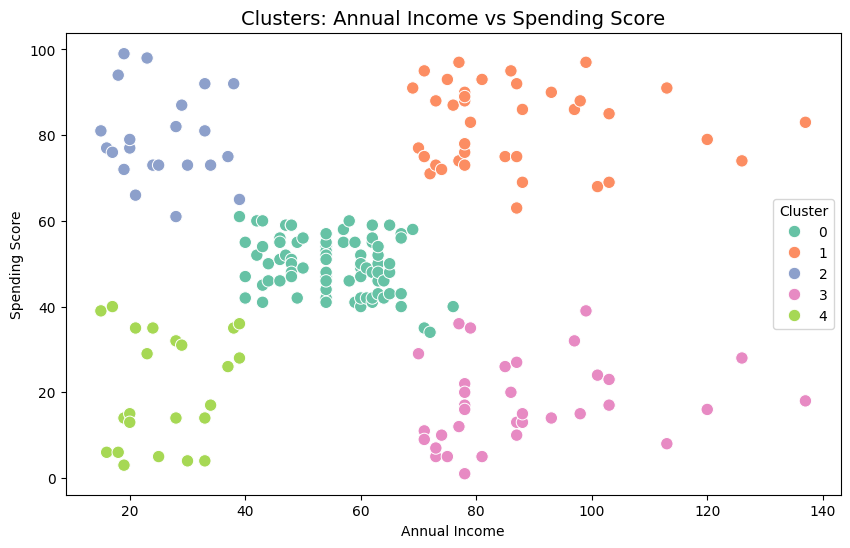

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="annual_income",
    y="spending_score",
    hue="cluster",
    palette="Set2",
    s=80
)
plt.title("Clusters: Annual Income vs Spending Score", fontsize=14)
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.legend(title="Cluster")
plt.show()


Temos o agrupamento acima possibilitando avaliar no detalhe cada cluster para entender o perfil de cada tipo de cliente, vamos agora identificar os clientes mais fiés ao shopping.

In [25]:
gender_counts = pd.crosstab(df['cluster'], df['gender']).reset_index()

agg = df.groupby('cluster', as_index=False).agg({
    'age': 'mean',
    'annual_income': 'mean',
    'spending_score': 'mean'
})

resultado = agg.merge(gender_counts, on='cluster')

In [26]:
resultado

,cluster,age,annual_income,spending_score,Female,Male
0,0,42.716049,55.296296,49.518519,48,33
1,1,32.692308,86.538462,82.128205,21,18
2,2,25.272727,25.727273,79.363636,13,9
3,3,41.114286,88.200000,17.114286,16,19
4,4,45.217391,26.304348,20.913043,14,9


Conforme a análise de médias dos clusters podemos tirar as seguintes conclusões:

- O cluster 1 é o que mais representa os clientes fiéis e com maior potencial de compra, pois tanto a renda anual quanto o score de gasto estão altos, indicando que são clientes que compram bastante no shopping e tem uma renda alta.
- Existe um potencial também no cluster 2 visto que também possuem um score alto, porém a renda anual não é tão alta assim, inclusive é a menor média de renda anual. É interessante avaliar até que ponto vale a pena investir nesses clientes.
- Clientes com potencial de subir para clientes fiéis são os cientes do cluster 0, é o cluster com mais clientes totalizando 81. Já possuem um score interessante, que é a média de 49 e uma receita anual também na média de todos os clusters então eles possuem um bom poder de compra.

**Portanto agora que sabemos os clientes mais fiéis (cluster 1) podemos tanto trabalhar em campanhas específicas para clientes prime, e podemos também trabalhar em campanhas para tornar os clientes do cluster 0 fiéis.**

# Próximos passos

Como próximos passos fica a sugestão de inserir mais um modelo para escolha dos melhores clusters que é o DBScan.